In [7]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from jupyterplot import ProgressPlot 
from matplotlib.animation import FuncAnimation

import copy
import numpy as np
import time
from collections import deque, OrderedDict
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
class DQN():
    def __init__(
            self,
            env,
            gamma,
            epsilon,
            numEpisodes,
            stateDim,
            actionDim,
            replayBufferSize,
            batchSize,
            epsilonDecay,
            epsilonDecayStart,
            lr,
    ):
        # Initialize DQN parameters and variables
        self.env = env  # Environment
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Initial exploration rate
        self.numEpisodes = numEpisodes  # Number of training episodes
        self.stateDim = stateDim  # Dimensionality of state space
        self.actionDim = actionDim  # Dimensionality of action space
        self.replayBufferSize = replayBufferSize  # Size of the replay buffer
        self.batchSize = batchSize  # Mini-batch size for training
        self.epsilonDecay = epsilonDecay  # Rate of exploration decay
        self.epsilonDecayStart = epsilonDecayStart  # Episode at which to start epsilon decay

        # Initialize counters and lists
        self.steps = 0
        self.sumRewardsEpisode = []  # Track sum of rewards per episode

        # Initialize replay buffer
        self.replayBuffer = deque(maxlen=self.replayBufferSize)

        # Initialize neural network
        self.network = self.createNetwork(self.stateDim, self.actionDim)

        # Initialize actions history
        self.actionsHistory = []

        # Initialize optimizer
        self.optim = torch.optim.Adam(self.network.parameters(), lr=lr)

    # Define the neural network architecture
    def createNetwork(self, inDim, outDim):
        return nn.Sequential(
            nn.Linear(inDim, 64),  # Input layer with ReLU activation
            nn.ReLU(),
            
            nn.Linear(64, 64),  # Hidden layer with ReLU activation
            nn.ReLU(),
            
            nn.Linear(64, 32),  # Another hidden layer with ReLU activation
            nn.ReLU(),
            
            nn.Linear(32, outDim),  # Output layer
        ).to(device)
    
    # Define custom loss function for DQN
    def my_loss(self, y_pred, y_true):
        # Calculate mean squared error loss only for the actions taken
        s1, s2 = y_true.shape
        loss = F.mse_loss(y_pred[torch.arange(s1), self.actionsHistory], y_true[torch.arange(s1), self.actionsHistory])
        return loss    
    
    # Train the network over multiple episodes
    def trainingEpisodes(self):
        # Initialize lists to store episode rewards and average Q values
        self.sumRewardsEpisode = []
        self.avgQ = []
        # Create plots to visualize training progress
        self.fig, self.ax = plt.subplots(2, 1, figsize=(7, 5))
        # Iterate over episodes
        for idx in tqdm(range(self.numEpisodes)):
            rewards = []
            # Reset environment and get initial state
            (currentState, _) = self.env.reset()
            terminalState = False
            print(f"Total steps: {self.steps}")
            self.Qs = []  # List to store Q values
            # Loop until episode termination
            while not terminalState:
                # Select action using epsilon-greedy policy
                action = self.selectAction(currentState, idx)
                # Take action and observe next state and reward
                (nextState, reward, terminalState, _, _) = self.env.step(action)
                rewards.append(reward)
                # Store experience in replay buffer
                self.replayBuffer.append((currentState, action, reward, nextState, terminalState))
                # Train the network
                self.trainNetwork()
                currentState = nextState
            
            # Store episode reward and average Q value
            self.sumRewardsEpisode.append(np.sum(rewards))
            self.avgQ.append(np.mean(self.Qs))
            # Update plots
            self.ax[0].clear()
            self.ax[1].clear()
            self.ax[0].plot(self.sumRewardsEpisode, label='Sum Rewards')
            self.ax[0].set_title('Sum Rewards Episode')
            self.ax[1].plot(self.avgQ, label='Average Q')
            self.ax[1].set_title('Average Q')
            self.ax[0].legend()
            self.ax[1].legend()
            plt.tight_layout()
            clear_output(wait=True)
            display(self.fig)
    
    # Select action using epsilon-greedy policy
    def selectAction(self, state, index):
        # Initial exploration phase
        if index == 0:
            return np.random.choice(self.actionDim)
        
        rand = np.random.random()
        # Decay exploration rate over time
        if index > self.epsilonDecayStart:
            self.epsilon *= self.epsilonDecay

        if rand < self.epsilon:
            return np.random.choice(self.actionDim)  # Random action
        # Exploit learned policy
        Q = self.network(torch.tensor(state.reshape(1, 4)).to(device))
        return torch.argmax(Q[0]).item()
    
    # Train the network using experiences from replay buffer
    def trainNetwork(self):
        if len(self.replayBuffer) > self.batchSize:
            # Sample a mini-batch from replay buffer
            randomBatch = random.sample(self.replayBuffer, self.batchSize)
            currentStateBatch = torch.zeros(size=(self.batchSize, 4)).to(device)
            nextStateBatch = torch.zeros(size=(self.batchSize, 4)).to(device)

            for index, tupleS in enumerate(randomBatch):
                # Extract data from the mini-batch
                currentStateBatch[index, :] = torch.tensor(tupleS[0])
                nextStateBatch[index, :] = torch.tensor(tupleS[3])

            # Set network to evaluation mode
            self.network.eval()
            QS_ = self.network(nextStateBatch)  # Compute Q-values for next states

            Y = torch.zeros((self.batchSize, 2)).to(device)
            self.actionsHistory = []
            rewards_batch = []
            for idx, (currentState, action, reward, nextState, terminated) in enumerate(randomBatch):
                rewards_batch.append(reward)
                if terminated:
                    y = reward
                else:
                    # Calculate target Q-value using target network
                    y = reward + self.gamma * torch.max(QS_[idx])
                self.actionsHistory.append(action)
                Y[idx, action] = y
            
            # Set network back to training mode
            self.network.train()

            # Zero out gradients
            self.optim.zero_grad()

            # Compute Q-values for current states
            QS = self.network(currentStateBatch).to(device)

            # Compute loss and backpropagate
            loss = self.my_loss(QS, Y)
            loss.backward()
            self.optim.step()  # Update network parameters

            self.Qs.append(QS.flatten().sum().item())  # Track sum of Q-values

            self.steps += 1  # Increment step counter


In [9]:
env = gym.make('CartPole-v1')

In [12]:
dqn = DQN(
    env=env,
    gamma=1,
    epsilon=0.1,
    numEpisodes=1000,
    stateDim=4,
    actionDim=2,
    replayBufferSize=256,
    batchSize=64,
    epsilonDecay=0.99,
    epsilonDecayStart=200,
    lr = 1e-3,
)

KeyboardInterrupt: 

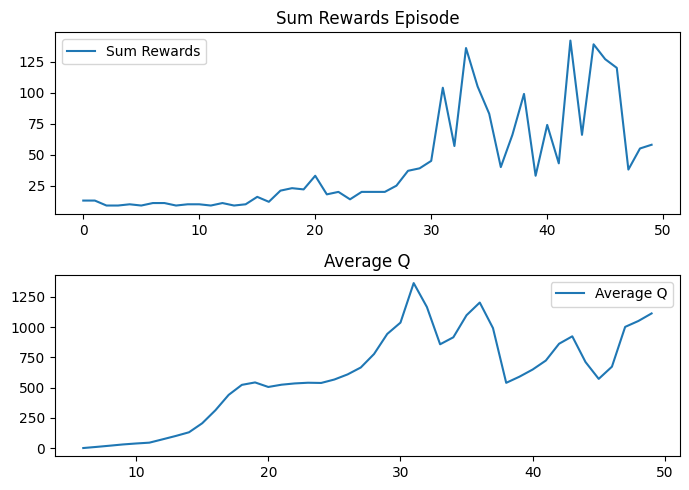

In [13]:
dqn.trainingEpisodes()

## Todo
- checkpoint
- tensorBoard
- .py
- params (yml)
- train, experiment
- use image
  - prepare dataset
  - train backbone
  - retrain 

## Observations
- Dropout significantly slows down training and is not worth it